### 1: Importing Packages

In [ ]:
import numpy as np
import pandas as pd
from numpy import array
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.formula.api as sm

### 2: Load Dataset 

In [63]:
# Load dataset
df = pd.read_csv("co2_emissions_from_agri.csv", delimiter=";")
df.drop(columns=["Unnamed: 31"], inplace=True)
df.head()

,Area,Year,Savanna_fires,Forest_fires,Crop_Residues,Rice_Cultivation,Drained_organic_soils_CO2,Pesticides_Manufacturing,Food_Transport,Forestland,...,Manure_Management,Fires_in_organic_soils,Fires_in_humid_tropical_forests,On_farm_energy_use,Rural_population,Urban_population,Total_Population_Male,Total_Population_Female,total_emission,Average_Temperature_C
0,Afghanistan,1990,14.7237,0.0557,205.6077,686.00,0.0,11.807483,63.1152,-2388.803,...,319.1763,0.0,0.0,141.0963,9655167.0,2593947.0,5348387.0,5346409.0,2198.963539,0.536167
1,Afghanistan,1991,14.7237,0.0557,209.4971,678.16,0.0,11.712073,61.2125,-2388.803,...,342.3079,0.0,0.0,141.0963,10230490.0,2763167.0,5372959.0,5372208.0,2323.876629,0.020667
2,Afghanistan,1992,14.7237,0.0557,196.5341,686.00,0.0,11.712073,53.3170,-2388.803,...,349.1224,0.0,0.0,141.0963,10995568.0,2985663.0,6028494.0,6028939.0,2356.304229,-0.259583
3,Afghanistan,1993,14.7237,0.0557,230.8175,686.00,0.0,11.712073,54.3617,-2388.803,...,352.2947,0.0,0.0,141.0963,11858090.0,3237009.0,7003641.0,7000119.0,2368.470529,0.101917
4,Afghanistan,1994,14.7237,0.0557,242.0494,705.60,0.0,11.712073,53.9874,-2388.803,...,367.6784,0.0,0.0,141.0963,12690115.0,3482604.0,7733458.0,7722096.0,2500.768729,0.372250


In [64]:
# Displays the number of rows and columns
df.shape

(6965, 31)

In [65]:
## Display summary information about the DataFrame.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6965 entries, 0 to 6964
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Area                             6965 non-null   object 
 1   Year                             6965 non-null   object 
 2   Savanna_fires                    6965 non-null   float64
 3   Forest_fires                     6965 non-null   float64
 4   Crop_Residues                    6965 non-null   float64
 5   Rice_Cultivation                 6965 non-null   float64
 6   Drained_organic_soils_CO2        6965 non-null   float64
 7   Pesticides_Manufacturing         6965 non-null   float64
 8   Food_Transport                   6965 non-null   float64
 9   Forestland                       6965 non-null   float64
 10  Net_Forest_conversion            6965 non-null   float64
 11  Food_Household_Consumption       6965 non-null   float64
 12  Food_Retail         

In [70]:
# Looking into the column Year because it is an object type
df['Year'].unique()

array(['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997',
       '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005',
       '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020',
       ' Hong Kong SAR', ' Macao SAR', ' mainland', ' Taiwan Province of',
       ' Ascension and Tristan da Cunha'], dtype=object)

In [71]:
# based on the above, we will drop specific non-numeric years

year_drop = np.array([' Hong Kong SAR', ' Macao SAR', ' mainland', ' Taiwan Province of',
       ' Ascension and Tristan da Cunha'])

df = df[~df['Year'].isin(year_drop)].copy()

# 2. Drop those rows
df = df.loc[~mask_non_numeric].copy()

# 3. Convert Year to integer
df["Year"] = df["Year"].astype(int)


### 3: Preliminary Data Analysis

In [72]:
# check for null values

df.isnull().sum()

Area                               0
Year                               0
Savanna_fires                      0
Forest_fires                       0
Crop_Residues                      0
Rice_Cultivation                   0
Drained_organic_soils_CO2          0
Pesticides_Manufacturing           0
Food_Transport                     0
Forestland                         0
Net_Forest_conversion              0
Food_Household_Consumption         0
Food_Retail                        0
On_farm_Electricity_Use            0
Food_Packaging                     0
Agrifood_Systems_Waste_Disposal    0
Food_Processing                    0
Fertilizers_Manufacturing          0
IPPU                               0
Manure_applied_to_Soils            0
Manure_left_on_Pasture             0
Manure_Management                  0
Fires_in_organic_soils             0
Fires_in_humid_tropical_forests    0
On_farm_energy_use                 0
Rural_population                   0
Urban_population                   0
T

In [73]:
# -------------------------------
# Outlier Detection & Handling
# -------------------------------

def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Example: detect outliers in total_emission
outliers_total_emission, lb, ub = detect_outliers_iqr(df, "total_emission")
print(f"Outliers in total_emission: {len(outliers_total_emission)} (Lower={lb:.2f}, Upper={ub:.2f})")

# Handling outliers by capping them
def handle_outliers_cap(data, column):
    outliers, lower_bound, upper_bound = detect_outliers_iqr(data, column)
    data[column] = data[column].clip(lower_bound, upper_bound)
    return data

df_clean = df.copy()
df_clean = handle_outliers_cap(df_clean, "total_emission")


Outliers in total_emission: 1131 (Lower=-38563.76, Upper=78118.64)


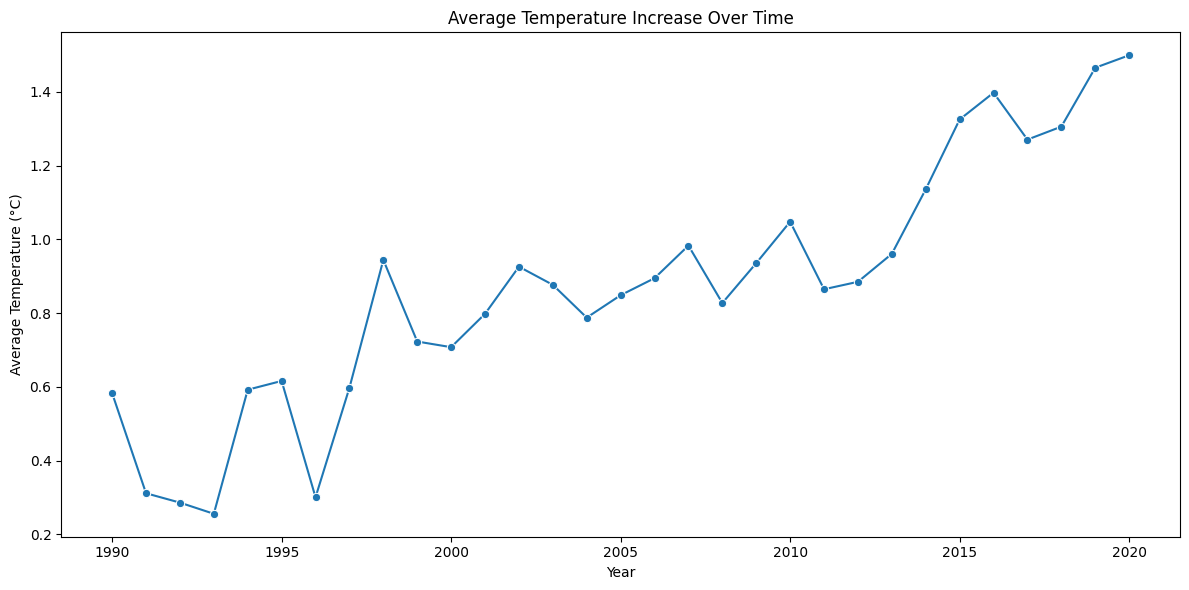

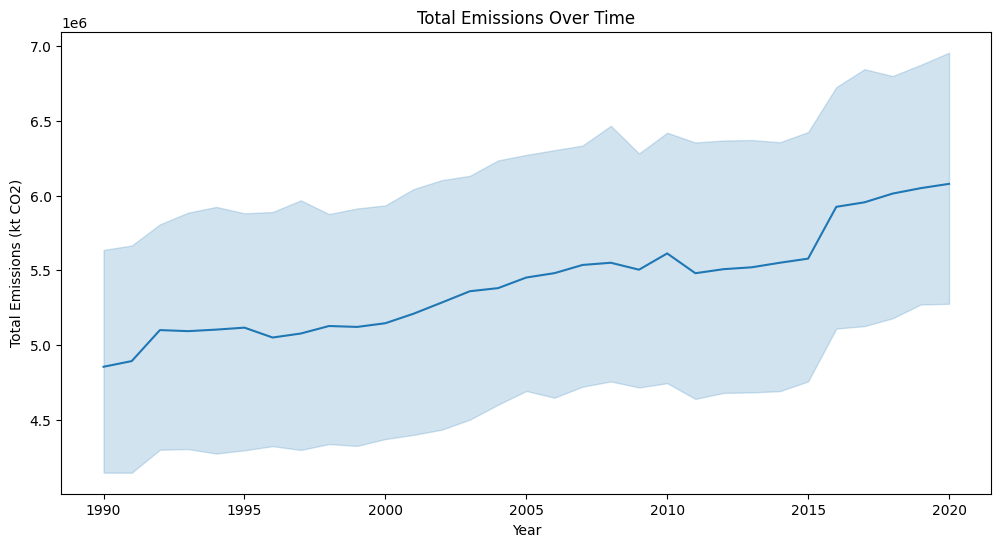

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

# Average Temperature over years
plt.figure(figsize=(12,6))
sns.lineplot(
    data=df_clean.groupby("Year", as_index=False)["Average_Temperature_C"].mean(),
    x="Year", y="Average_Temperature_C", marker="o"
)
plt.title("Average Temperature Increase Over Time")
plt.xlabel("Year")
plt.ylabel("Average Temperature (°C)")
plt.tight_layout()
plt.show()

# Total Emissions over years
plt.figure(figsize=(12,6))
sns.lineplot(data=df_clean, x="Year", y="total_emission", estimator="sum")
plt.title("Total Emissions Over Time")
plt.xlabel("Year")
plt.ylabel("Total Emissions (kt CO2)")

plt.show()


In [92]:
df_clean.head()

,Area,Year,Savanna_fires,Forest_fires,Crop_Residues,Rice_Cultivation,Drained_organic_soils_CO2,Pesticides_Manufacturing,Food_Transport,Forestland,...,Manure_Management,Fires_in_organic_soils,Fires_in_humid_tropical_forests,On_farm_energy_use,Rural_population,Urban_population,Total_Population_Male,Total_Population_Female,total_emission,Average_Temperature_C
0,Afghanistan,1990,14.7237,0.0557,205.6077,686.00,0.0,11.807483,63.1152,-2388.803,...,319.1763,0.0,0.0,141.0963,9655167.0,2593947.0,5348387.0,5346409.0,2198.963539,0.536167
1,Afghanistan,1991,14.7237,0.0557,209.4971,678.16,0.0,11.712073,61.2125,-2388.803,...,342.3079,0.0,0.0,141.0963,10230490.0,2763167.0,5372959.0,5372208.0,2323.876629,0.020667
2,Afghanistan,1992,14.7237,0.0557,196.5341,686.00,0.0,11.712073,53.3170,-2388.803,...,349.1224,0.0,0.0,141.0963,10995568.0,2985663.0,6028494.0,6028939.0,2356.304229,-0.259583
3,Afghanistan,1993,14.7237,0.0557,230.8175,686.00,0.0,11.712073,54.3617,-2388.803,...,352.2947,0.0,0.0,141.0963,11858090.0,3237009.0,7003641.0,7000119.0,2368.470529,0.101917
4,Afghanistan,1994,14.7237,0.0557,242.0494,705.60,0.0,11.712073,53.9874,-2388.803,...,367.6784,0.0,0.0,141.0963,12690115.0,3482604.0,7733458.0,7722096.0,2500.768729,0.372250


In [99]:
# Check if emissions are identical across different countries in the same year
pivot_check = (
    df_clean
    .groupby(["Year"])["total_emission"]
    .nunique()
    .reset_index()
)
print(pivot_check.head(20))


    Year  total_emission
0   1990             171
1   1991             172
2   1992             188
3   1993             191
4   1994             191
5   1995             191
6   1996             190
7   1997             189
8   1998             188
9   1999             190
10  2000             191
11  2001             190
12  2002             190
13  2003             187
14  2004             187
15  2005             184
16  2006             185
17  2007             185
18  2008             185
19  2009             187


In [41]:
# load descriptive stats

df_clean.describe(include='all')

,Area,Year,Savanna_fires,Forest_fires,Crop_Residues,Rice_Cultivation,Drained_organic_soils_CO2,Pesticides_Manufacturing,Food_Transport,Forestland,...,Manure_Management,Fires_in_organic_soils,Fires_in_humid_tropical_forests,On_farm_energy_use,Rural_population,Urban_population,Total_Population_Male,Total_Population_Female,total_emission,Average_Temperature_C
count,6965,6965,6965.000000,6965.000000,6965.000000,6965.000000,6965.000000,6965.000000,6965.000000,6965.000000,...,6965.000000,6965.000000,6965.000000,6965.000000,6.965000e+03,6.965000e+03,6.965000e+03,6.965000e+03,6965.000000,6.965000e+03
unique,232,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,China,2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,155,222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,1226.302308,904.674811,701.153959,3694.295550,4174.499995,302.640495,1867.035641,-14437.116704,...,1966.188694,1497.051271,653.568748,2145.358625,1.452581e+07,1.760358e+07,1.724784e+07,1.745490e+07,26853.875961,8.525639e+03
std,NaN,NaN,5233.743632,3696.780294,2815.661133,14828.325211,18562.815165,1268.547788,5444.039411,72722.939371,...,7183.669009,23038.193388,3229.848647,9611.710237,7.436011e+07,7.208932e+07,7.358031e+07,7.365515e+07,31329.772626,1.313639e+05
min,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-797183.079000,...,0.432900,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,2.500000e+02,2.700000e+02,-43463.345507,-1.415833e+00
25%,NaN,NaN,0.000000,0.000000,18.980300,155.025800,0.000000,5.000000,26.262663,-2161.005000,...,52.530700,0.000000,0.000000,14.954900,8.461300e+04,1.894500e+05,2.035650e+05,2.072460e+05,5221.243741,5.170000e-01
50%,NaN,NaN,2.256400,0.517900,103.698200,466.480000,0.000000,12.437201,195.973700,-62.920000,...,269.856300,0.000000,0.000000,141.096300,1.448639e+06,2.309436e+06,2.469660e+06,2.444135e+06,12672.717049,8.485833e-01
75%,NaN,NaN,168.403200,61.237200,264.718000,1463.391166,777.965728,111.000000,1168.195400,0.000000,...,883.170300,0.000000,6.919200,778.268000,7.987242e+06,8.043241e+06,9.075924e+06,9.112588e+06,37677.636573,1.236091e+00


In [42]:
target = 'Average_Temperature_C'

# 1) Ensure target is numeric (coerce any accidental strings)
df_clean[target] = pd.to_numeric(df_clean[target], errors='coerce')

# 2) Keep only numeric columns
num_df = df_clean.select_dtypes(include=['number']).copy()

# 3) If Year was object earlier, you can coerce it first (optional)
# df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

# 4) Correlation matrix on numeric-only data
corr_matrix = num_df.corr()

# 5) Correlations with the target (sorted by absolute strength)
corr_with_target = corr_matrix[target].dropna().reindex(
    corr_matrix[target].abs().sort_values(ascending=False).index
)

print("Correlation with Average_Temperature_C (strongest first):")
print(corr_with_target)

Correlation with Average_Temperature_C (strongest first):
Average_Temperature_C              1.000000
Manure_applied_to_Soils            0.985387
Food_Retail                        0.893581
Fertilizers_Manufacturing          0.806376
Food_Processing                    0.606694
Urban_population                   0.586560
Total_Population_Female            0.558827
Total_Population_Male              0.527266
Drained_organic_soils_CO2          0.477753
Manure_Management                  0.456862
Food_Packaging                     0.444356
On_farm_Electricity_Use            0.426775
Agrifood_Systems_Waste_Disposal    0.380305
Net_Forest_conversion             -0.309740
Manure_left_on_Pasture             0.172293
Pesticides_Manufacturing           0.171474
Fires_in_organic_soils             0.165588
total_emission                     0.122249
Rice_Cultivation                   0.102675
Food_Transport                     0.100388
IPPU                               0.086716
Forestland        

Based on the output of the correlation above, we can see that the following variables are highly positively correlated with Average Temperature: 
    1. Manure_applied_to_Soils            
    2. total_emission                     
    3. Food_Retail                        
    4. Fertilizers_Manufacturing          
    5. Food_Processing



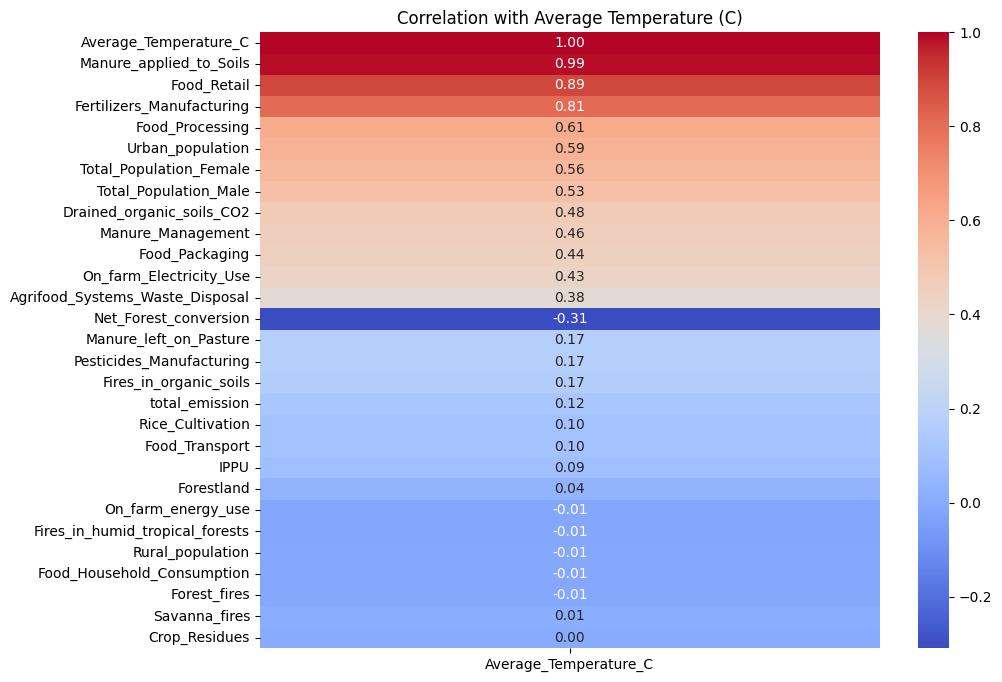

In [43]:
# Heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_with_target.to_frame(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation with Average Temperature (C)')
plt.show()

## 4. Data preprocessing & Model Evaluation

We prepare the data for modelling by splitting it into training and testing sets and scaling the features to help our models perform optimally.

Both Area and Year were dropped from the dataset as they are not directly related to sustainable farming practices. 

In the below code block, we prepare our features `X` and target variable `y` for modelling. The dataset is also split into training and testing sets, and feature scaling is applied using `MinMaxScaler`. This process ensures that our regression models do not bias towards variables with larger magnitudes.

In [44]:
# Separate the feature and target variables
X = df_clean.drop(['Average_Temperature_C', 'Area', 'Year'], axis=1)
y = df_clean['Average_Temperature_C']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
# Initialize and apply MinMaxScaler for scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [45]:
# Preparing data for simple linear regression using Manure_applied_to_Soils as it had the highest correlation with target variable

X_train_lr = pd.DataFrame(X_train_scaled, columns=X.columns)[['Manure_applied_to_Soils']]
X_test_lr = pd.DataFrame(X_test_scaled, columns=X.columns)[['Manure_applied_to_Soils']]

# Training the model
model_lr = LinearRegression()
model_lr.fit(X_train_lr, y_train)

# Making predictions on the test data
y_pred_lr = model_lr.predict(X_test_lr)

# Evaluating the model
print(f"R² Score: {r2_score(y_test, y_pred_lr)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_lr)}")

R² Score: 0.9800577968962272
MSE: 530391924.2396134


Our simple linear regression model performed relatively well with an R-squared value above 0.7, but it could probably be improved by adding a few more variables to the model. Let's see how this compares to the performance of other more complex models.

In [47]:
def train_and_evaluate_model(model):
    
    # Train the model on the scaled training data
    model.fit(X_train_scaled, y_train)
    
    # Make predictions on the scaled test set
    predictions = model.predict(X_test_scaled)
    
    # Evaluate the model
    r2 = r2_score(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    
    return model, r2, mse

In [48]:
# Training and evaluating the multiple linear regression model
linear_model, linear_r2, linear_mse = train_and_evaluate_model(LinearRegression())
print(f"Linear regression - R²: {linear_r2}, MSE: {linear_mse}")

Linear regression - R²: 0.9965549690700702, MSE: 91625613.00184332


We can see that the model has performed better, given the increase in the R² score and a decrease in the MSE. It would be interesting to test this model with only the strongest predictors as well – it could be informative to assess whether there is a big drop in predictive power if we drop some of the weaker predictors. 

In [49]:
# Training and evaluating the decision tree regression model
tree_model, tree_r2, tree_mse = train_and_evaluate_model(DecisionTreeRegressor(random_state=42, max_depth=4))
print(f"Decision tree regression - R²: {tree_r2}, MSE: {tree_mse}")

Decision tree regression - R²: 0.994520900161828, MSE: 145724636.89927933


The decision tree does not perform as well as expected. It could be because there are several variables included that don't hold that much predictive power or the fact that our tree has a max_depth parameter that was set to 4, which is quite shallow. Ideally, we should run multiple iterations of decision trees, with different parameters to determine the optimal fit.

In [50]:
# Training and evaluating the random forest regression model
forest_model, forest_r2, forest_mse = train_and_evaluate_model(RandomForestRegressor(random_state=42, max_depth=6))
print(f"Random Forest Regression - R²: {forest_r2}, MSE: {forest_mse}")

Random Forest Regression - R²: 0.9987704905947822, MSE: 32700592.603070065


We can see an improvement in the performance of our model. This is because random forests, by aggregating the predictions of numerous decision trees, reduce the risk of overfitting and offer a more generalisable model.

Let's also try and capitalise on the unique strengths of other different model types than just the decision trees. To be precise, we will apply stacking where we will train a meta-learner based on the outputs of some base models.

We will use some of the models we have already trained as our base learners and a new model as the meta-learner.

Let's start by defining our base models and the meta-learner:

## Model Stability with Cross-Validation
To better understand model robustness, we evaluate performance using 5-fold cross-validation.


In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Define CV strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Linear Regression CV
lin_reg = LinearRegression()
lin_scores = cross_val_score(lin_reg, X, y, cv=cv, scoring="r2")
print("Linear Regression CV R² scores:", lin_scores)
print("Mean R²:", np.mean(lin_scores), "| Std Dev:", np.std(lin_scores))

# Random Forest CV
rf = RandomForestRegressor(n_estimators=200, random_state=42, max_depth=6)
rf_scores = cross_val_score(rf, X, y, cv=cv, scoring="r2")
print("Random Forest CV R² scores:", rf_scores)
print("Mean R²:", np.mean(rf_scores), "| Std Dev:", np.std(rf_scores))

Linear Regression CV R² scores: [0.99655497 0.99696547 0.99908172 0.99533705 0.99473027]
Mean R²: 0.9965338942077056 | Std Dev: 0.0015075547868082806
Random Forest CV R² scores: [0.99858141 0.99898056 0.99535827 0.9952357  0.9976167 ]
Mean R²: 0.9971545272277897 | Std Dev: 0.0015806601977317078


In [51]:
# Define the base models: these are models that have already been trained
base_models = [
    ('linear_regression', linear_model),
    ('random_forest', forest_model)
]

# Define the meta-learner
final_estimator = LinearRegression()

In [52]:
# Training and evaluating the stacking regression model
stacking_model, stacking_r2, stacking_mse = train_and_evaluate_model(StackingRegressor(estimators=base_models, final_estimator=final_estimator, cv=5))
print(f"Stacking Regression - R²: {stacking_r2}, MSE: {stacking_mse}")

Stacking Regression - R²: 0.9980371612151909, MSE: 52204555.064935155


Considering all the different model approaches and evaluations made, a feature importance test was run to determine which features have a large enough impact to remain in the model. 

In [53]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns)
print(importances.sort_values(ascending=False).head(10))


Manure_applied_to_Soils            0.872115
Net_Forest_conversion              0.023814
Urban_population                   0.020068
Food_Retail                        0.018358
Fertilizers_Manufacturing          0.010707
Forestland                         0.006246
Agrifood_Systems_Waste_Disposal    0.005980
Total_Population_Female            0.005802
Savanna_fires                      0.005270
Total_Population_Male              0.004708
dtype: float64


## Feature Selection Stability
To verify whether the same features remain important across different data splits, we evaluate feature importances across CV folds.


In [56]:
from collections import defaultdict

feature_importance_tracker = defaultdict(list)

for train_idx, test_idx in cv.split(X, y):
    X_train_cv, y_train_cv = X.iloc[train_idx], y.iloc[train_idx]
    rf_cv = RandomForestRegressor(n_estimators=200, random_state=42, max_depth=6)
    rf_cv.fit(X_train_cv, y_train_cv)
    
    for feat, importance in zip(X.columns, rf_cv.feature_importances_):
        feature_importance_tracker[feat].append(importance)

# Convert to DataFrame for inspection
import pandas as pd
fi_stability = pd.DataFrame(feature_importance_tracker)
fi_mean = fi_stability.mean().sort_values(ascending=False)
fi_std  = fi_stability.std().sort_values(ascending=False)

print("Feature Importance Stability (mean importance):")
print(fi_mean.head(10))

print("\nFeature Importance Variability (std across folds):")
print(fi_std.head(10))

Feature Importance Stability (mean importance):
Manure_applied_to_Soils            0.848762
Net_Forest_conversion              0.040567
Food_Retail                        0.020015
Urban_population                   0.016312
Fertilizers_Manufacturing          0.016100
Agrifood_Systems_Waste_Disposal    0.006235
Forestland                         0.005740
Food_Processing                    0.005168
Savanna_fires                      0.005035
Food_Packaging                     0.004755
dtype: float64

Feature Importance Variability (std across folds):
Manure_applied_to_Soils            0.018692
Fertilizers_Manufacturing          0.015914
Net_Forest_conversion              0.013411
Food_Retail                        0.007364
Urban_population                   0.002199
Forestland                         0.002043
Food_Packaging                     0.002011
Agrifood_Systems_Waste_Disposal    0.001822
Rural_population                   0.001737
Rice_Cultivation                   0.001644
dtype

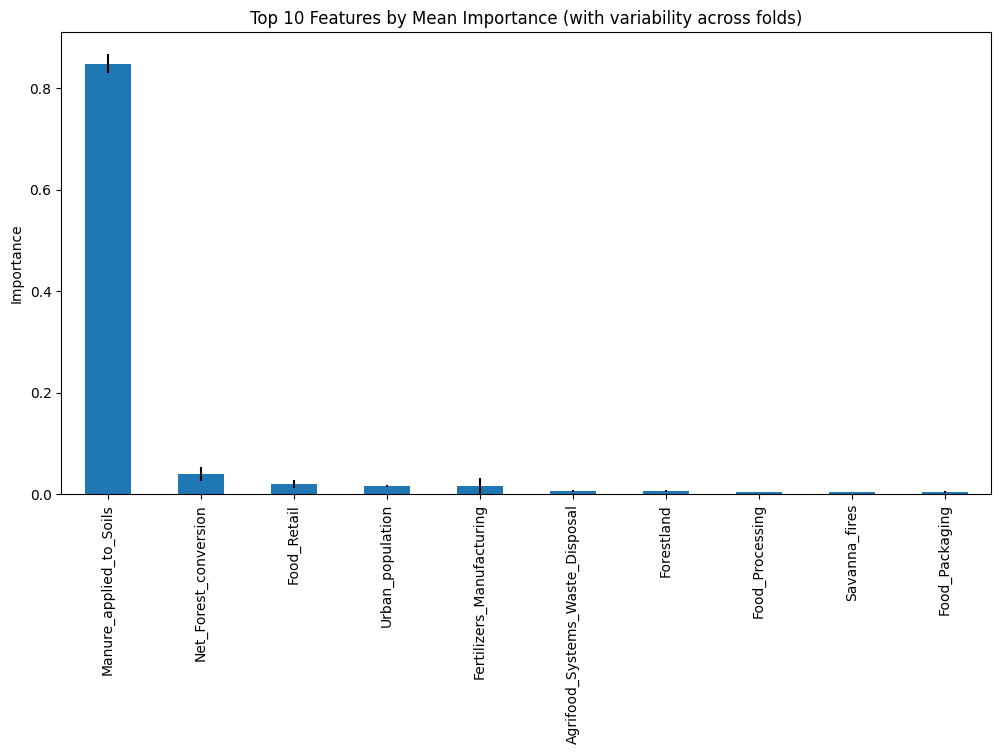

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
fi_mean.head(10).plot(kind="bar", yerr=fi_std.head(10))
plt.title("Top 10 Features by Mean Importance (with variability across folds)")
plt.ylabel("Importance")
plt.show()
